In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import plotly.express as px

import pickle
from joblib import dump, load

In [2]:
ML_dataframe = pd.read_csv('./ML_dataframe.csv')
ML_dataframe

,humidity,longitude,latitude,date,temperature,precipitation,wind_speed,fire
0,0.011474,-117.0,32.5,2015-08-11,296.54483,0.0,0.000000,0.0
1,0.009796,-116.5,32.5,2015-08-11,296.70218,0.0,0.000000,0.0
2,0.008041,-116.0,32.5,2015-08-11,302.85245,0.0,0.000000,0.0
3,0.011642,-117.0,33.0,2015-08-11,296.78555,0.0,4.758888,0.0
4,0.009769,-116.5,33.0,2015-08-11,296.72223,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...
5668,0.000000,-123.0,38.5,2015-08-20,0.00000,0.0,4.923879,0.0
5669,0.000000,-124.0,39.5,2015-08-20,0.00000,0.0,3.997697,0.0
5670,0.000000,-124.0,40.0,2015-08-20,0.00000,0.0,3.725361,0.0
5671,0.000000,-124.5,40.5,2015-08-20,0.00000,0.0,6.733368,0.0


## Perform PCA analysis

In [3]:
# Scale data

df_scaled = scale(ML_dataframe.drop(['date','latitude','longitude','fire'], axis = 1))
df_scaled

array([[ 1.85390621,  0.22287541, -0.18466947, -1.44906414],
       [ 1.24284625,  0.22508313, -0.18466947, -1.44906414],
       [ 0.60355588,  0.31137533, -0.18466947, -1.44906414],
       ...,
       [-2.32557496, -3.93783709, -0.18466947,  0.14698336],
       [-2.32557496, -3.93783709, -0.18466947,  1.43569685],
       [-2.32557496, -3.93783709, -0.18466947,  0.15623564]])

In [4]:
# Perform PCA analysis

pca_4 = PCA(n_components = 4)
pca_4.fit(df_scaled)

df_transformed = pca_4.fit_transform(df_scaled)

[0.40155871 0.2542383  0.23944018 0.10476282]


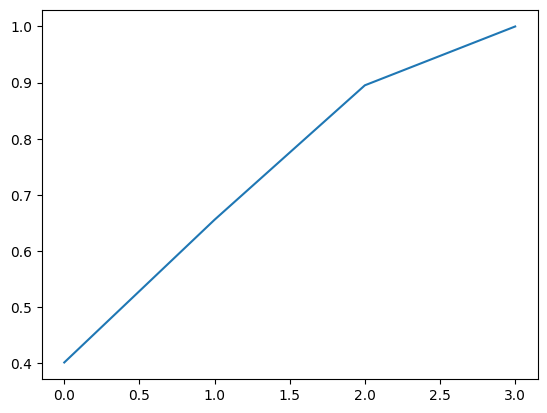

In [5]:
# See explained variances (if can data can be cut to smaller dimensions)

print(pca_4.explained_variance_ratio_)

plt.plot(np.cumsum(pca_4.explained_variance_ratio_))

plt.show()

In [6]:
# Define new PCA to get two largest components

pca_2 = PCA(n_components = 2)

df_new = pca_2.fit_transform(df_scaled)
df_new.shape

(5673, 2)

In [7]:
# Create Loading Matrix to see breakdown of two largest principal components

loading_matrix = pd.DataFrame(df_transformed[-2:].T* np.sqrt(pca_2.explained_variance_), 
                              columns=['PC1', 'PC2'], index=ML_dataframe.columns[[0,4,5,6]])
loading_matrix

,PC1,PC2
humidity,-5.812367,-4.404849
temperature,-0.154826,0.768978
precipitation,1.215496,0.069657
wind_speed,-1.296639,-1.154912


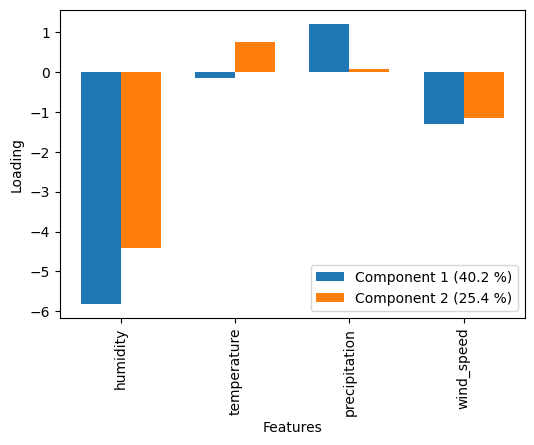

In [8]:
# Plot breakdowns of two largest principal components

ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(ind, loading_matrix['PC1'], width, 
       label='Component 1 ({:.1f} %)'.format(pca_4.explained_variance_ratio_[0] * 100))
ax.bar(ind + width, loading_matrix['PC2'], width, 
       label='Component 2 ({:.1f} %)'.format(pca_4.explained_variance_ratio_[1] * 100))
ax.set_xlabel('Features')
ax.set_ylabel('Loading')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.show()

## Random forest

In [9]:
# Prepare X and y

X = ML_dataframe.drop(['latitude','longitude','date','fire'], axis = 1)
scaled_X = StandardScaler().fit_transform(X)

y = ML_dataframe['fire']
scaled_X

array([[ 1.85390621,  0.22287541, -0.18466947, -1.44906414],
       [ 1.24284625,  0.22508313, -0.18466947, -1.44906414],
       [ 0.60355588,  0.31137533, -0.18466947, -1.44906414],
       ...,
       [-2.32557496, -3.93783709, -0.18466947,  0.14698336],
       [-2.32557496, -3.93783709, -0.18466947,  1.43569685],
       [-2.32557496, -3.93783709, -0.18466947,  0.15623564]])

In [10]:
# Split data into training and test data

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, random_state=0)
X_train.shape, X_test.shape

((4254, 4), (1419, 4))

In [11]:
# Fit random forest classifier

rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [12]:
# Test classifer is 100% accurate on training data

y_pred_train_rf = rf_classifier.predict(X_train)
rf_training_accuracy = rf_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {rf_training_accuracy:.1f} %')

Accuracy on training data: 100.0 %


In [13]:
# Test classifier on test data

y_pred_rf = rf_classifier.predict(X_test)
rf_testing_accuracy = rf_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {rf_testing_accuracy:.1f} %')

Accuracy on testing data: 94.6 %


In [14]:
# Get classification data

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1351
         1.0       0.32      0.10      0.16        68

    accuracy                           0.95      1419
   macro avg       0.64      0.55      0.56      1419
weighted avg       0.93      0.95      0.93      1419



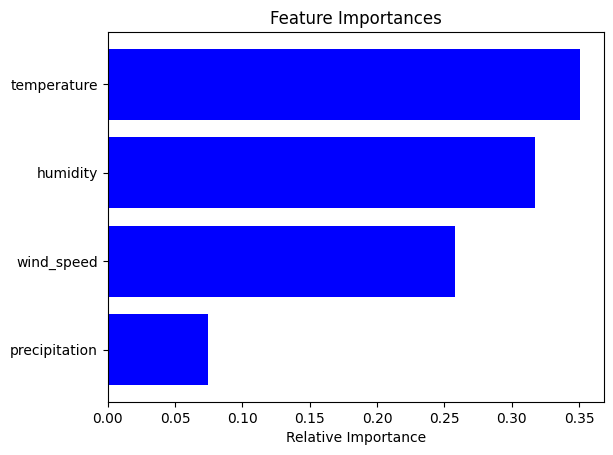

In [15]:
rf_feature_importances = rf_classifier.feature_importances_
rf_feature_importances_std = X.columns

features = X.columns
rf_indices = np.argsort(rf_feature_importances)

plt.title('Feature Importances')
plt.barh(range(len(rf_indices)), rf_feature_importances[rf_indices], color='b', align='center')
plt.yticks(range(len(rf_indices)), [features[i] for i in rf_indices])
plt.xlabel('Relative Importance')
plt.show()

## Standard Vector Machine

In [26]:
# Fit svm model

svc_classifier = SVC(random_state=42, gamma='auto')
svc_classifier.fit(X_train, y_train)

SVC(gamma='auto', random_state=42)

In [27]:
# Test svm model on test data

y_pred_svm = svc_classifier.predict(X_test)
svm_testing_accuracy = svc_classifier.score(X_test, y_test) * 100
print(f'Accuracy on training data: {svm_testing_accuracy:.1f} %')

Accuracy on training data: 95.2 %


In [28]:
# Get classification model on SVM data

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      1351
         1.0       0.00      0.00      0.00        68

    accuracy                           0.95      1419
   macro avg       0.48      0.50      0.49      1419
weighted avg       0.91      0.95      0.93      1419



/Users/maxdolan/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/maxdolan/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/maxdolan/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Plot RF model

In [29]:
data = ML_dataframe[['humidity','temperature','precipitation','wind_speed']]
ML_dataframe['fire_prediction'] = rf_classifier.predict(StandardScaler().fit_transform(data))
ML_dataframe[['probability_0','probability_1']] = rf_classifier.predict_proba(StandardScaler().fit_transform(data))
ML_dataframe

,humidity,longitude,latitude,date,temperature,precipitation,wind_speed,fire,fire_prediction,probability_0,probability_1
0,0.011474,-117.0,32.5,2015-08-11,296.54483,0.0,0.000000,0.0,0.0,0.99,0.01
1,0.009796,-116.5,32.5,2015-08-11,296.70218,0.0,0.000000,0.0,0.0,0.89,0.11
2,0.008041,-116.0,32.5,2015-08-11,302.85245,0.0,0.000000,0.0,0.0,1.00,0.00
3,0.011642,-117.0,33.0,2015-08-11,296.78555,0.0,4.758888,0.0,0.0,0.99,0.01
4,0.009769,-116.5,33.0,2015-08-11,296.72223,0.0,0.000000,0.0,0.0,0.99,0.01
...,...,...,...,...,...,...,...,...,...,...,...
5668,0.000000,-123.0,38.5,2015-08-20,0.00000,0.0,4.923879,0.0,0.0,1.00,0.00
5669,0.000000,-124.0,39.5,2015-08-20,0.00000,0.0,3.997697,0.0,0.0,1.00,0.00
5670,0.000000,-124.0,40.0,2015-08-20,0.00000,0.0,3.725361,0.0,0.0,1.00,0.00
5671,0.000000,-124.5,40.5,2015-08-20,0.00000,0.0,6.733368,0.0,0.0,1.00,0.00


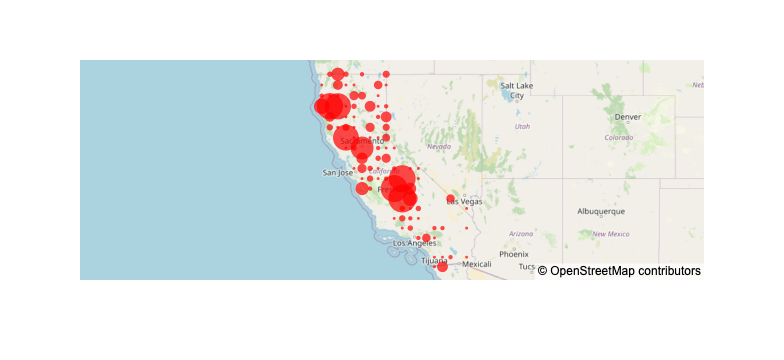

In [30]:
fig = px.scatter_mapbox(ML_dataframe[ML_dataframe['date'] == '2015-08-11'],
                        lat = 'latitude',
                        lon = 'longitude',
                        size = 'probability_1',
                        color_discrete_sequence = ['red']*len(ML_dataframe),
                        mapbox_style = 'open-street-map',
                        zoom = 3.5)
fig.show()

## Save classifiers as pickle

In [21]:
# Save rf classifier

rf_model = pickle.dumps(rf_classifier)
dump(rf_classifier, 'rf_classifier.joblib')

['rf_classifier.joblib']

In [31]:
# Save svm classifier

svc_model = pickle.dumps(svc_classifier)
dump(svc_classifier, 'svc_classifier.joblib')

['svc_classifier.joblib']

In [34]:
sum(svc_classifier.predict(StandardScaler().fit_transform(data)))

0.0